# Mini project 8.3.2

# Inferential Statistics:  Bayesian

## Set up

In [1]:
# Load libraries

import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Add seaborn
import seaborn as sns

In [2]:
# Set default seaborn style

sns.set()

## Load data

In [3]:
medical = pd.read_csv('insurance2.csv')

## Clean data

In [4]:
# Set up insured and not insured samples

insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)
n_ins, n_no_ins

(783, 555)

## Explore 

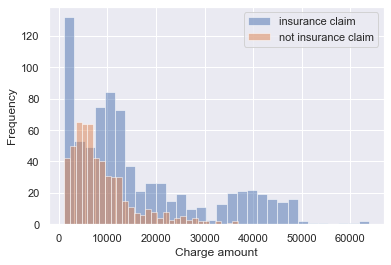

In [5]:
# Inspect the two samples

_ = plt.hist(insurance, bins=30, alpha=.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

## Do a first simulation

An initial guess for the gamma distribution's $\alpha$ and $\beta$ parameters can be made as described [here](https://wiki.analytica.com/index.php?title=Gamma_distribution).

In [6]:
# Do a prior estimate for gramma distributions alpha and beta parameters

alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250857, 4702.486170152821)

In [7]:
# Create a distribution by drawing random variates

seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

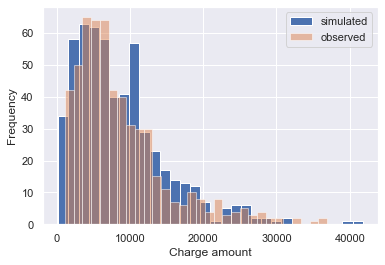

In [8]:
# Compare the original to simulated samples

_ = plt.hist(no_ins_model_rvs, bins=30, alpha=1, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

## Take Bayesian approach to improving our simulated sample

### Create a model using PyMC3

In [9]:
# Tranform parameters to work with PyMC3

# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est

# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

In [10]:
# Set up model

with pm.Model() as model_no_ins_pymc3:
    alpha_ = pm.Exponential('alpha', 1/alpha_est)
    rate_ = pm.Exponential('beta', 1/rate_est)
    mc3_dist = pm.Gamma('no_insurance', alpha=alpha_, beta=rate_, observed=no_insurance)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:11<00:00, 3665.99draws/s]


__Q:__ Explore your posteriors for $\alpha$ and $\beta$ (from the trace).
* Calculate the 95% credible interval for $\alpha$ and $\beta$.
* Plot your posterior values of $\alpha$ and $\beta$ (both line plots and histograms). 
* Mark your CIs on the histograms.
* Do they look okay? What would bad plots look like?

In [11]:
# Get traces (i.e., samples)

alpha_samples = trace['alpha']
beta_samples = trace['beta']
alpha_samples, beta_samples

(array([2.23623949, 2.32708006, 2.26442336, ..., 2.26819344, 2.15783066,
        2.42363084]),
 array([0.00025503, 0.00026259, 0.00025712, ..., 0.00025036, 0.00024837,
        0.00027196]))

In [12]:
# Calc confidence internal for alpha using percentiles

alpha_ci = np.percentile(alpha_samples, [2.5, 97.5])
print('The 95% confidenice interval for alpha is from {} to {}'.format(alpha_ci[0], alpha_ci[1]))

The 95% confidenice interval for alpha is from 1.989920523281183 to 2.4830568660033543


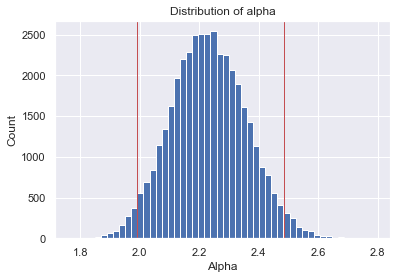

In [13]:
# Inspect histogram of alpha

_ = plt.hist(alpha_samples, bins=50)
_ = plt.xlabel('Alpha')
_ = plt.ylabel('Count')
_ = plt.title('Distribution of alpha')
_ = plt.axvline(alpha_ci[0], color='r', linestyle='solid', linewidth=1)
_ = plt.axvline(alpha_ci[1], color='r', linestyle='solid', linewidth=1)

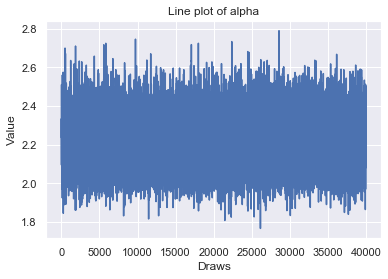

In [14]:
# Inspect line plot of alpha

_ = plt.plot(alpha_samples)
_ = plt.xlabel('Draws')
_ = plt.ylabel('Value')
_ = plt.title('Line plot of alpha')

In [15]:
# Calc confidence internal for beta

beta_ci = np.percentile(beta_samples, [2.5, 97.5])
print('The 95% confidenice interval for alpha is from {} to {}'.format(beta_ci[0], beta_ci[1]))

The 95% confidenice interval for alpha is from 0.0002222373041779064 to 0.0002850215364193945


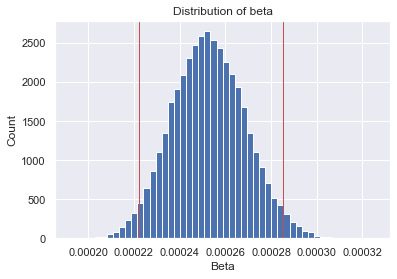

In [16]:
# Inspect histogram of beta

_ = plt.hist(beta_samples, bins=50)
_ = plt.xlabel('Beta')
_ = plt.ylabel('Count')
_ = plt.title('Distribution of beta')
_ = plt.axvline(beta_ci[0], color='r', linestyle='solid', linewidth=1)
_ = plt.axvline(beta_ci[1], color='r', linestyle='solid', linewidth=1)

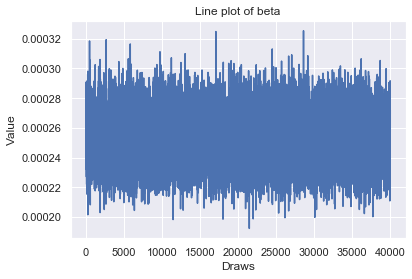

In [17]:
# Inspect line plot of beta

_ = plt.plot(beta_samples)
_ = plt.xlabel('Draws')
_ = plt.ylabel('Value')
_ = plt.title('Line plot of beta')

Takeways:
    
* Yes, the graphs look OK
* Bad histograms would look a lot less normal
* Bad line plots would look a lot less random

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


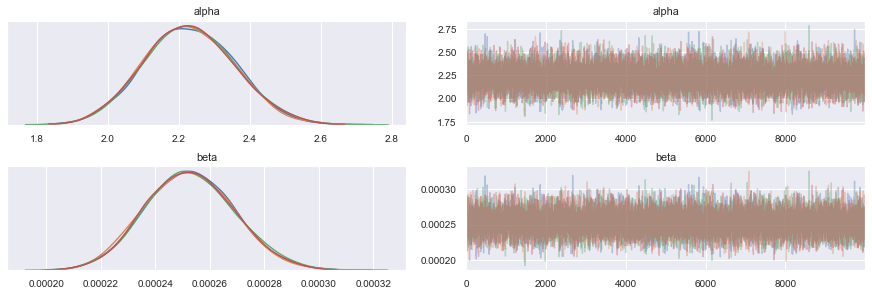

In [18]:
_ = pm.plots.traceplot(trace)

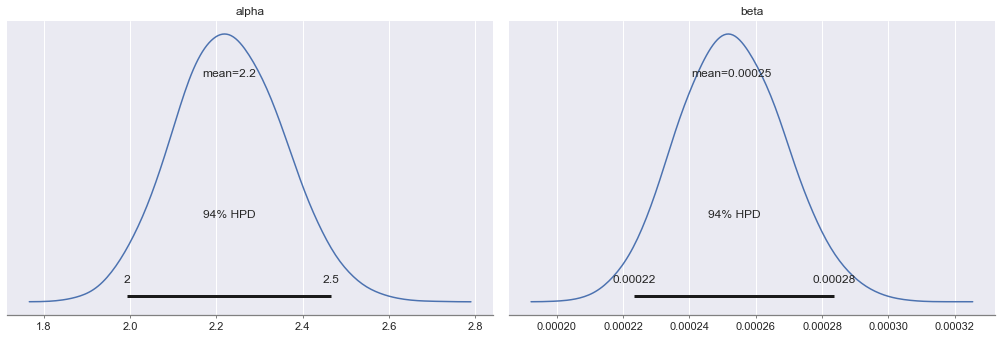

In [19]:
_ = pm.plots.plot_posterior(trace)

Takeway:
    
* Looks fine

## Simulate a better sample

__Q:__ Take your best shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution. Don't forget the difference between functions that take $\beta$ and functions that use $1/\beta$ for the scale parameter. Simulate a data set the same size as the number of observations in the data and overlay the two histograms (simulated and observed).

In [20]:
# Set up prior

alpha_best_shot = np.mean(alpha_samples)
beta_best_shot = np.mean(beta_samples)
rate_best_shot = 1/beta_best_shot
alpha_best_shot, rate_best_shot

(2.2302696042655787, 3956.851413537265)

In [21]:
# Create a distribution by drawing random variates

seed(47)
best_shot_simulated = gamma(alpha_best_shot, scale=rate_best_shot).rvs(n_no_ins)

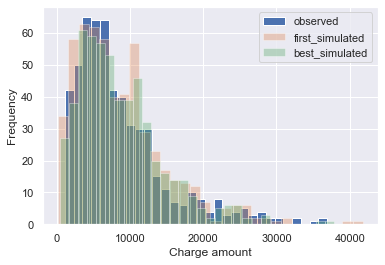

In [22]:
# Visualize the simulated and observed histograms

_ = plt.hist(no_insurance, bins=30, alpha=1, label='observed')
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.35, label='first_simulated')
_ = plt.hist(best_shot_simulated, bins=30, alpha=0.35, label='best_simulated')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

Takeaway:

* Our second (best_shot) sample might look a bit improved--mainly in the tail